# PosePrior Demo

This notebook contains code to convert `PosePrior` as implemented in "Learning to Estimate 3D Hand Pose from Single RGB Images" by Zimmerman et al. Their project is available at [https://github.com/lmb-freiburg/hand3d].

In [14]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.model.PoseNet import PoseNet
from colorhandpose3d.model.PosePrior import PosePrior
from colorhandpose3d.model.ViewPoint import ViewPoint
from colorhandpose3d.utils.general import *

## Initialize Models

`PosePrior` depends on the output of `HandSegNet`+`PoseNet`. First define the required models.

In [15]:
handsegnet = HandSegNet()
posenet = PoseNet()
poseprior = PosePrior()

handsegnet.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar'))
posenet.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/posenet.pth.tar'))

## Import weights from Tensorflow model

The weights are saved in `pickle` format from the Tensorflow model.

In [16]:
file_name = '/home/ajdillhoff/Downloads/ColorHandPose3D_data_v3/weights/posenet3d-rhd-stb-slr-finetuned.pickle'
session = tf.Session()
exclude_var_list = list()

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'PosePrior' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k in keys]
    
for name, module in poseprior.named_children():
    key = 'PosePrior/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        if len(w.shape) == 4:
            w = w.permute((3, 2, 1, 0))
        else:
            w = w.transpose(0, 1)
        module.weight.data = w
        module.bias.data = b
        
torch.save(poseprior.state_dict(), '/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/poseprior.pth.tar')

## Load and run sample

Run a sample through the network.

In [27]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/00007.png')
sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - 0.5

# Run through network
output = handsegnet.forward(sample)

# Calculate single highest scoring object
test_output = single_obj_scoremap(output, 21)

# Crop and resize
centers, bbs, crops = calc_center_bb(test_output)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(test_output, centers, crop_size, scale_crop)

# also take a sample crop with mean subtracted
sample_crop = crop_image_from_xy(sample, centers, crop_size, scale_crop)

# PoseNet
keypoints_scoremap = posenet(sample_crop)

### PosePrior Network

PosePrior takes as input the keypoints scoremap and outputs the coordinates in 3D space.

In [38]:
hand_side = torch.Tensor([[1, 0]])

# PosePrior
keypoint_coord3d = poseprior(keypoints_scoremap, hand_side)

### Viewpoint network

The final network in Zimmerman et al.'s approach estimates the rotation parameters to transform the canonical coordinates to real coordinates.

In [29]:
viewpoint = ViewPoint()

In [30]:
file_name = '/home/ajdillhoff/Downloads/ColorHandPose3D_data_v3/weights/posenet3d-rhd-stb-slr-finetuned.pickle'
session = tf.Session()
exclude_var_list = list()

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'ViewpointNet' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k in keys]
    
for name, module in viewpoint.named_children():
    key = 'ViewpointNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        if len(w.shape) == 4:
            w = w.permute((3, 2, 1, 0))
        else:
            w = w.transpose(0, 1)
        module.weight.data = w
        module.bias.data = b
        
torch.save(viewpoint.state_dict(), '/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/viewpoint.pth.tar')

In [31]:
rot_params = viewpoint(keypoints_scoremap, hand_side)

## Convert ViewPoint output to transformation matrix

The axis-angle parameters output by the ViewPoint network need to be converted to a transformation matrix.

In [32]:
def get_rotation_matrix(rot_params):
    """Converts axis-angle parameters to a rotation matrix.
    
    The axis-angle parameters have an encoded angle.
    
    Args:
        rot_params - Tensor (batch x 3): ux, uy, uz axis-angle parameters.
        
    Returns:
        rot_matrix - Tensor (batch x 3 x 3): Rotation matrices.
    """
    
    theta = rot_params.norm(dim=1)
    
    st = torch.sin(theta)
    ct = torch.cos(theta)
    one_ct = 1.0 - torch.cos(theta)
    
    norm_fac = 1.0 / theta
    ux = rot_params[:, 0] * norm_fac
    uy = rot_params[:, 1] * norm_fac
    uz = rot_params[:, 2] * norm_fac
    
    top = torch.stack((ct + ux * ux * one_ct, ux * uy * one_ct - uz * st, ux * uz * one_ct + uy * st), dim=1)
    mid = torch.stack((uy * ux * one_ct + uz * st, ct + uy * uy * one_ct, uy * uz * one_ct - ux * st), dim=1)
    bot = torch.stack((uz * ux * one_ct - uy * st, uz * uy * one_ct + ux * st, ct + uz * uz * one_ct), dim=1)
    
    rot_matrix = torch.stack((top, mid, bot), dim=1)
    return rot_matrix


def flip_right_hand(coords_xyz_canonical, cond_right):
    """Flips the given canonical coordinates, when cond_right is true.
    
    The returned coordinates represent those of the left hand.
    
    Args:
        coords_xyz_canonical - Tensor (batch x 3 x num_keypoints): Coordinates for each keypoint.
        cond_right - Tensor (batch x 3 x num_keypoints): Values are 0 or 1 depending on if the keypoints
            represent the right hand.
            
    Returns:
        coords_xyz_canonical_left - Tensor (batch x 3 x num_keypoints): Resulting coordinates. Remain
            unchanged if cond_right is False.
    """
    
    s = coords_xyz_canonical.shape
    assert len(s) == 3, "coords_xyz_canonical must be (batch x 3 x num_keypoints)."
    assert len(cond_right.shape) == 3, "cond_right must be (batch x 3 x num_keypoints)."
    
    coords_xyz_canonical_mirrored = coords_xyz_canonical
    coords_xyz_canonical_mirrored[:, :, 2] *= -1.
    
    coords_xyz_canonical_left = torch.where(cond_right, coords_xyz_canonical_mirrored, coords_xyz_canonical)
    
    return coords_xyz_canonical_left

In [33]:
rot_matrix = get_rotation_matrix(rot_params)

### Normalized 3D coordinates

With the rotation matrices, the normalized 3D coordinates can be computed.

In [42]:
cond_right = torch.eq(torch.argmax(hand_side, 1), 1)
cond_right_all = torch.reshape(cond_right, [-1, 1, 1]).repeat(1, 21, 3)
coords_xyz_can_flip = flip_right_hand(keypoint_coord3d, cond_right_all)
coords_xyz_rel_normed = coords_xyz_can_flip @ rot_matrix

## Visualize the result

Now that the 3D coordinates are calculated, the result can be visualized.

In [35]:
def plot_hand_3d(coords_xyz, axis, color_fixed=None, linewidth='1'):
    """Plots a hand stick figure into a matplotlib figure. """
    colors = np.array([[0., 0., 0.5],
                       [0., 0., 0.73172906],
                       [0., 0., 0.96345811],
                       [0., 0.12745098, 1.],
                       [0., 0.33137255, 1.],
                       [0., 0.55098039, 1.],
                       [0., 0.75490196, 1.],
                       [0.06008855, 0.9745098, 0.90765338],
                       [0.22454143, 1., 0.74320051],
                       [0.40164453, 1., 0.56609741],
                       [0.56609741, 1., 0.40164453],
                       [0.74320051, 1., 0.22454143],
                       [0.90765338, 1., 0.06008855],
                       [1., 0.82861293, 0.],
                       [1., 0.63979666, 0.],
                       [1., 0.43645606, 0.],
                       [1., 0.2476398, 0.],
                       [0.96345811, 0.0442992, 0.],
                       [0.73172906, 0., 0.],
                       [0.5, 0., 0.]])

    # define connections and colors of the bones
    bones = [((0, 4), colors[0, :]),
             ((4, 3), colors[1, :]),
             ((3, 2), colors[2, :]),
             ((2, 1), colors[3, :]),

             ((0, 8), colors[4, :]),
             ((8, 7), colors[5, :]),
             ((7, 6), colors[6, :]),
             ((6, 5), colors[7, :]),

             ((0, 12), colors[8, :]),
             ((12, 11), colors[9, :]),
             ((11, 10), colors[10, :]),
             ((10, 9), colors[11, :]),

             ((0, 16), colors[12, :]),
             ((16, 15), colors[13, :]),
             ((15, 14), colors[14, :]),
             ((14, 13), colors[15, :]),

             ((0, 20), colors[16, :]),
             ((20, 19), colors[17, :]),
             ((19, 18), colors[18, :]),
             ((18, 17), colors[19, :])]

    for connection, color in bones:
        coord1 = coords_xyz[connection[0], :]
        coord2 = coords_xyz[connection[1], :]
        coords = np.stack([coord1, coord2])
        if color_fixed is None:
            axis.plot(coords[:, 0], coords[:, 1], coords[:, 2], color=color, linewidth=linewidth)
        else:
            axis.plot(coords[:, 0], coords[:, 1], coords[:, 2], color_fixed, linewidth=linewidth)

    axis.view_init(azim=-90., elev=90.)

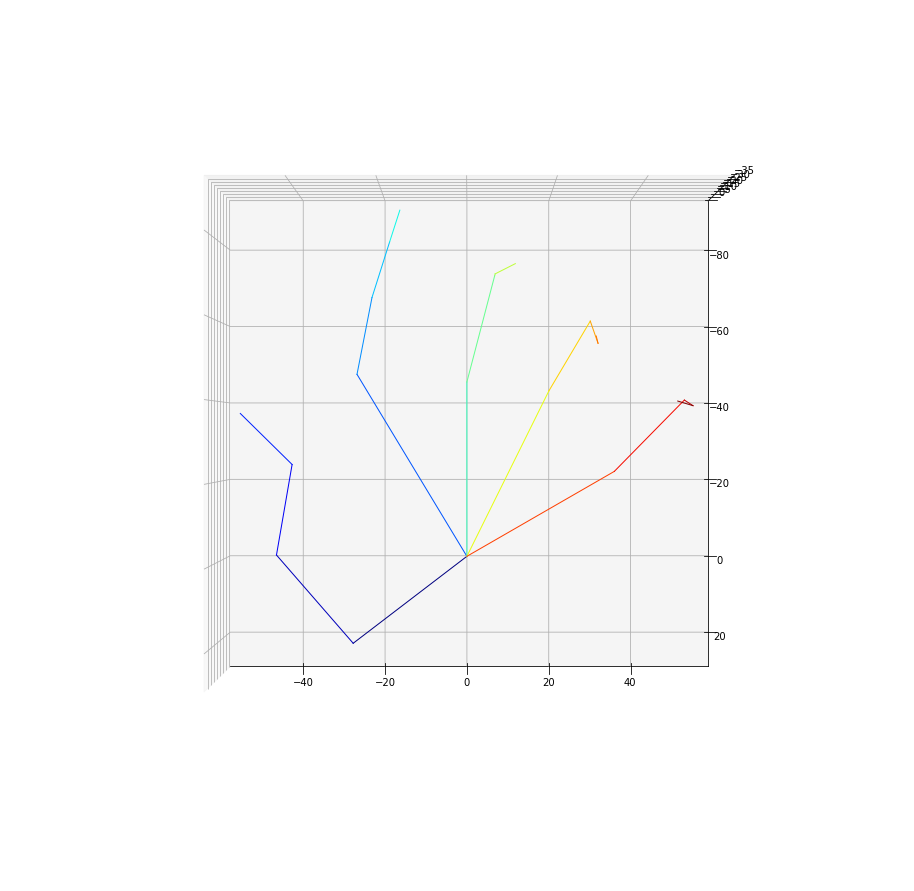

In [41]:
fig = plt.figure(1, figsize=(16, 16))
ax1 = fig.add_subplot(111, projection='3d')
keypoint_coords3d = coords_xyz_rel_normed.detach().numpy()
keypoint_coords3d = keypoint_coords3d.squeeze()
plot_hand_3d(keypoint_coord3d.detach().numpy().squeeze(), ax1)
ax1.view_init(azim=-90.0, elev=-90.0)
# ax1.set_xlim([-3, 3])
# ax1.set_ylim([-3, 1])
# ax1.set_zlim([-3, 3])
plt.show()